# RSM8521 - Assignment 3
## Bhavana Balakrishna Rao - 1008221023

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load Data

Upload the files to your Google Drive and mount it in the Colab notebook using the code below.

Files: `promos.csv.gz`, `test_history.csv.gz`, `train_history.csv.gz`, and `transactions.csv.gz`.

In [2]:
# This will ask you to give Colab permission to access your Google Drive 
# and enter an authorization code.
# See: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# MODIFY THIS LINE with the path to where you saved the datafiles on your Google drive
path = '/content/drive/My Drive/DL-Assignment3'

Data Dictionary - 
https://docs.google.com/spreadsheets/d/1ob3JMpi6XNJJb88N8VXIT5S7zWQAMaUV/edit#gid=1975743370

## Promo Data

In [4]:
promos = pd.read_csv(path + '/promos.csv.gz')
promos.head()

,promo,category,promoqty,manufacturer,promoval,brand
0,209524,51006740,1,1593002228,1.00,189092190
1,176321,42760698,1,1957688344,0.75,1386413202
2,17125,56844954,1,629075831,1.50,1429623935
3,177412,56844954,1,629075831,1.50,1429623935
4,69839,56844954,1,629075831,1.50,1429623935


In [5]:
promos.describe()

,promo,category,promoqty,manufacturer,promoval,brand
count,24.000000,2.400000e+01,24.0,2.400000e+01,24.000000,2.400000e+01
mean,118249.208333,5.481441e+07,1.0,6.133263e+08,1.500000,9.903851e+08
std,62318.021405,2.071678e+07,0.0,5.924728e+08,0.466252,6.200337e+08
min,17125.000000,8.946099e+06,1.0,1.072165e+08,0.750000,8.614511e+07
25%,72764.000000,5.088380e+07,1.0,1.228016e+08,1.250000,3.247888e+08
50%,97093.500000,5.684495e+07,1.0,3.506702e+08,1.500000,8.858470e+08
75%,176593.750000,7.522819e+07,1.0,7.593778e+08,1.500000,1.429624e+09
max,222088.000000,8.138216e+07,1.0,2.037187e+09,3.000000,2.395930e+09


In [6]:
promos.info() # no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   promo         24 non-null     int64  
 1   category      24 non-null     int64  
 2   promoqty      24 non-null     int64  
 3   manufacturer  24 non-null     int64  
 4   promoval      24 non-null     float64
 5   brand         24 non-null     int64  
dtypes: float64(1), int64(5)
memory usage: 1.2 KB


## Train History

In [7]:
train_history = pd.read_csv(path + '/train_history.csv.gz', parse_dates=['promodate'])
train_history.head()

,id,store,promo,region,promodate,active
0,115562959531,860548,176321,243820,2013-03-25,0.0
1,175261390705,625933,37568,191747,2013-03-15,0.0
2,273751574633,527828,209524,165933,2013-03-23,1.0
3,166923268906,1056730,214816,5506,2013-03-20,0.0
4,135410903443,241369,176321,278897,2013-03-25,0.0


In [8]:
train_history.shape

(20000, 6)

In [9]:
train_history.describe()

,id,store,promo,region,active
count,2.000000e+04,2.000000e+04,20000.000000,20000.000000,20000.000000
mean,1.496756e+11,5.627027e+05,146415.750400,180934.916750,0.202500
std,8.631886e+10,2.773112e+05,56222.645015,85957.192596,0.401873
min,3.215936e+07,7.845000e+03,17125.000000,5506.000000,0.000000
25%,7.464556e+10,3.554710e+05,108252.000000,132336.000000,0.000000
50%,1.496330e+11,5.539740e+05,176321.000000,191747.000000,0.000000
75%,2.238695e+11,7.381370e+05,176321.000000,243820.000000,0.000000
max,2.998685e+11,1.155220e+06,214816.000000,334402.000000,1.000000


In [10]:
train_history.info() # no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         20000 non-null  int64         
 1   store      20000 non-null  int64         
 2   promo      20000 non-null  int64         
 3   region     20000 non-null  int64         
 4   promodate  20000 non-null  datetime64[ns]
 5   active     20000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 937.6 KB


In [11]:
train_history['id'].nunique()

20000

## Test History

In [12]:
test_history = pd.read_csv(path + '/test_history.csv.gz', parse_dates=['promodate'])
test_history.head()

,id,store,promo,region,promodate,active
0,250462324156,457755,96852,191747,2013-04-22,NaN
1,61214568335,740794,54956,203586,2013-04-23,NaN
2,274776763999,394092,95011,42773,2013-04-02,NaN
3,91546215019,876095,108237,323706,2013-04-24,NaN
4,220718580189,625933,222088,191747,2013-04-18,NaN


In [13]:
test_history.shape

(10000, 6)

In [14]:
test_history.describe()

,id,store,promo,region,active
count,1.000000e+04,1.000000e+04,10000.00000,10000.000000,0.0
mean,1.507647e+11,5.698603e+05,109051.13850,179220.896300,NaN
std,8.661267e+10,2.657908e+05,44021.46639,85304.433845,NaN
min,5.863125e+07,7.845000e+03,32358.00000,5506.000000,NaN
25%,7.495212e+10,3.940920e+05,95011.00000,132336.000000,NaN
50%,1.518053e+11,5.205290e+05,96852.00000,191747.000000,NaN
75%,2.256346e+11,7.034930e+05,108237.00000,206022.000000,NaN
max,2.998636e+11,1.155220e+06,222088.00000,334402.000000,NaN


In [15]:
test_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         10000 non-null  int64         
 1   store      10000 non-null  int64         
 2   promo      10000 non-null  int64         
 3   region     10000 non-null  int64         
 4   promodate  10000 non-null  datetime64[ns]
 5   active     0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 468.9 KB


In [16]:
test_history['id'].nunique()

10000

## Transaction

In [17]:
transactions = pd.read_csv(path + '/transactions.csv.gz', parse_dates=['date'])
transactions.head()

,id,store,market_group,category,manufacturer,brand,date,productsize,measure,qty,amt
0,31924309471,96431,360548,10881580,707582354,109487351,2012-03-06,28.00,OZ,1,2.69
1,31924309471,96431,80472,75959720,2052533430,254982935,2012-03-06,12.00,OZ,2,8.48
2,31924309471,96431,194893,80209099,1640770606,1252530761,2012-03-06,6.00,OZ,1,1.69
3,31924309471,96431,27828,10942974,946555356,2133681340,2012-03-06,0.75,LT,1,11.41
4,31924309471,96431,135933,64737859,700393013,221618334,2012-03-06,33.84,OZ,1,3.19


In [18]:
transactions.shape

(34184139, 11)

In [19]:
transactions.describe()

,id,store,market_group,category,manufacturer,brand,productsize,qty,amt
count,3.418414e+07,3.418414e+07,3.418414e+07,3.418414e+07,3.418414e+07,3.418414e+07,3.418414e+07,3.418414e+07,3.418414e+07
mean,1.482967e+11,5.701235e+05,3.657040e+05,4.561211e+07,1.099001e+09,1.140853e+09,2.720696e+01,1.962315e+00,5.455355e+00
std,8.417071e+10,2.743823e+05,2.156516e+05,2.465871e+07,7.136837e+08,6.886597e+08,5.132527e+01,3.220290e+01,2.962413e+01
min,3.215936e+07,7.845000e+03,4.288000e+03,2.508700e+04,1.277200e+05,1.860280e+05,0.000000e+00,-2.070000e+02,-5.477480e+03
25%,8.326266e+10,3.674890e+05,1.778150e+05,2.428169e+07,3.915232e+08,5.414240e+08,7.000000e+00,1.000000e+00,2.000000e+00
50%,1.420346e+11,5.941190e+05,3.258750e+05,4.971439e+07,1.075867e+09,1.139556e+09,1.340000e+01,1.000000e+00,3.290000e+00
75%,2.189977e+11,7.407940e+05,5.653960e+05,6.770007e+07,1.722781e+09,1.686479e+09,2.400000e+01,2.000000e+00,5.290000e+00
max,2.998685e+11,1.155220e+06,8.182400e+05,8.278046e+07,2.334650e+09,2.417328e+09,6.000000e+03,4.480000e+04,2.546754e+04


In [20]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34184139 entries, 0 to 34184138
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   store         int64         
 2   market_group  int64         
 3   category      int64         
 4   manufacturer  int64         
 5   brand         int64         
 6   date          datetime64[ns]
 7   productsize   float64       
 8   measure       object        
 9   qty           int64         
 10  amt           float64       
dtypes: datetime64[ns](1), float64(2), int64(7), object(1)
memory usage: 2.8+ GB


In [21]:
transactions.isnull().sum()

id                   0
store                0
market_group         0
category             0
manufacturer         0
brand                0
date                 0
productsize          0
measure         971343
qty                  0
amt                  0
dtype: int64

In [22]:
print('Number of unique customers: {}'.format(transactions['id'].nunique()))
print('Number of unique stores: {}'.format(transactions['store'].nunique()))
print('Number of unique market_group: {}'.format(transactions['market_group'].nunique()))
print('Number of unique category: {}'.format(transactions['category'].nunique()))
print('Number of unique manufacturer: {}'.format(transactions['manufacturer'].nunique()))
print('Number of unique brand: {}'.format(transactions['brand'].nunique()))
print('Earliest date: {}'.format(transactions['date'].min()))
print('Latest date: {}'.format(transactions['date'].max()))

Number of unique customers: 29988
Number of unique stores: 116
Number of unique market_group: 83
Number of unique category: 829
Number of unique manufacturer: 23347
Number of unique brand: 24174
Earliest date: 2012-03-02 00:00:00
Latest date: 2013-02-28 00:00:00


# Extract Features

## Compute RFM Features

In [23]:
max_date = transactions.date.max()
transactions['last_purchase'] = (max_date - transactions['date']) / np.timedelta64(1, "D")

# Agg transaction data to id
trans_features = transactions.groupby('id').agg({
    'last_purchase': 'min', # get the number of days before max date the person purchases i.e. the most freqent purchase
    'date': ['nunique', 'min'], # nunique: number of different days the customer bought the product; min: date of first purchase
    'amt': 'sum', # sum of all purchases
})

# Compute RFM columns
trans_features['recency'] = trans_features['last_purchase']['min']
trans_features['frequency'] = (trans_features['date']['nunique']  # number of transaction divided by the number of days between first and last purchase
                               / ((max_date - trans_features['date']['min']) / np.timedelta64(1, "D"))) 
trans_features['monetary'] = trans_features['amt']['sum']

# Select out required features
trans_features = trans_features[['recency', 'frequency', 'monetary']].reset_index()
trans_features.columns = trans_features.columns.get_level_values(0)
trans_features.head()

,id,recency,frequency,monetary
0,32159355,3.0,0.201117,3141.84
1,38085541,4.0,0.146814,2231.17
2,41697872,0.0,0.248619,5006.52
3,54676900,0.0,0.245810,1793.02
4,58631253,0.0,0.251381,4926.40


In [24]:
# Generate feature dataframe
features = train_history.merge(trans_features, on='id', how='left')
features.recency.fillna(365, inplace=True)
features.frequency.fillna(0, inplace=True)
features.monetary.fillna(0, inplace=True)
features.head()

,id,store,promo,region,promodate,active,recency,frequency,monetary
0,115562959531,860548,176321,243820,2013-03-25,0.0,0.0,0.150000,2697.93
1,175261390705,625933,37568,191747,2013-03-15,0.0,13.0,0.086835,1938.51
2,273751574633,527828,209524,165933,2013-03-23,1.0,6.0,0.069277,420.44
3,166923268906,1056730,214816,5506,2013-03-20,0.0,1.0,0.212885,3823.56
4,135410903443,241369,176321,278897,2013-03-25,0.0,2.0,0.146409,3787.26


## Day-of-the-week Features

In [25]:
# merge promo with features
features = features.merge(promos, on='promo', how='left')

# was the promo offered on a weekday or weekend?
features['promo_in_weekend'] = features['promodate'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)

features.head()

,id,store,promo,region,promodate,active,recency,frequency,monetary,category,promoqty,manufacturer,promoval,brand,promo_in_weekend
0,115562959531,860548,176321,243820,2013-03-25,0.0,0.0,0.150000,2697.93,42760698,1,1957688344,0.75,1386413202,0
1,175261390705,625933,37568,191747,2013-03-15,0.0,13.0,0.086835,1938.51,75228190,1,1154816776,2.00,1234009542,0
2,273751574633,527828,209524,165933,2013-03-23,1.0,6.0,0.069277,420.44,51006740,1,1593002228,1.00,189092190,1
3,166923268906,1056730,214816,5506,2013-03-20,0.0,1.0,0.212885,3823.56,8946099,1,1150283635,2.00,86145108,0
4,135410903443,241369,176321,278897,2013-03-25,0.0,2.0,0.146409,3787.26,42760698,1,1957688344,0.75,1386413202,0


In [26]:
transactions['weekend'] = transactions['date'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)
transactions.head()

,id,store,market_group,category,manufacturer,brand,date,productsize,measure,qty,amt,last_purchase,weekend
0,31924309471,96431,360548,10881580,707582354,109487351,2012-03-06,28.00,OZ,1,2.69,359.0,0
1,31924309471,96431,80472,75959720,2052533430,254982935,2012-03-06,12.00,OZ,2,8.48,359.0,0
2,31924309471,96431,194893,80209099,1640770606,1252530761,2012-03-06,6.00,OZ,1,1.69,359.0,0
3,31924309471,96431,27828,10942974,946555356,2133681340,2012-03-06,0.75,LT,1,11.41,359.0,0
4,31924309471,96431,135933,64737859,700393013,221618334,2012-03-06,33.84,OZ,1,3.19,359.0,0


## Product-related Features

In [27]:
# product features
category_count = transactions[['id', 'category']].groupby('category').agg('count') # total sales (count) of that product
category_count = category_count.reset_index(level=0)
category_count = category_count.rename(columns={'id': 'category_count'})
category_count.head()

,category,category_count
0,25087,436213
1,56797,103899
2,182921,6644
3,184380,4681
4,201779,97765


## Customer-related Features

In [28]:
# customer features
customer_features = transactions.groupby('id').agg({
    'id' : 'count',         # number of products (category) bought by the customer
    'category' : 'nunique', # number of unique products purchased by the customer
    'weekend' : 'sum'})     # number of products purchased vy the customer on weekend 
customer_features = customer_features.rename(columns={'id':'total_products_count', 'category': 'unique_products_count', 'weekend': 'total_products_weekend'})
customer_features = customer_features.reset_index(level=0)
customer_features['products_weekend_pct'] = customer_features['total_products_weekend'] / customer_features['total_products_count'] # percentage of purchases on the weekend
customer_features.head()

,id,total_products_count,unique_products_count,total_products_weekend,products_weekend_pct
0,32159355,642,227,177,0.275701
1,38085541,607,154,217,0.357496
2,41697872,1206,247,793,0.657546
3,54676900,625,111,83,0.132800
4,58631253,1185,246,533,0.449789


In [29]:
# customer - product features 
customer_product_features = transactions.groupby(['id', 'category']).agg({
    'id':'count',  # no. of times the user bought that product
    'weekend' : 'sum'}) # no. of times the user bought that product on a weekend
customer_product_features = customer_product_features.rename(columns={'id':'cust_prod_count', 'weekend': 'cust_prod_weekend_count'})
customer_product_features = customer_product_features.reset_index()
customer_product_features['cust_prod_weekend_pct'] = customer_product_features['cust_prod_weekend_count'] / customer_product_features['cust_prod_count'] # percentage of purchases on the weekend
customer_product_features.head()

,id,category,cust_prod_count,cust_prod_weekend_count,cust_prod_weekend_pct
0,32159355,56797,1,1,1.0
1,32159355,201779,2,0,0.0
2,32159355,472968,3,0,0.0
3,32159355,1125818,8,0,0.0
4,32159355,1281213,1,0,0.0


In [30]:
features = features.merge(category_count, on='category', how='left')
features = features.merge(customer_features, on='id', how='left')
features.total_products_count.fillna(0, inplace=True)
features.unique_products_count.fillna(0, inplace=True)
features.head()

,id,store,promo,region,promodate,active,recency,frequency,monetary,category,promoqty,manufacturer,promoval,brand,promo_in_weekend,category_count,total_products_count,unique_products_count,total_products_weekend,products_weekend_pct
0,115562959531,860548,176321,243820,2013-03-25,0.0,0.0,0.150000,2697.93,42760698,1,1957688344,0.75,1386413202,0,26537,698.0,203.0,198.0,0.283668
1,175261390705,625933,37568,191747,2013-03-15,0.0,13.0,0.086835,1938.51,75228190,1,1154816776,2.00,1234009542,0,16392,593.0,139.0,107.0,0.180438
2,273751574633,527828,209524,165933,2013-03-23,1.0,6.0,0.069277,420.44,51006740,1,1593002228,1.00,189092190,1,391325,155.0,86.0,64.0,0.412903
3,166923268906,1056730,214816,5506,2013-03-20,0.0,1.0,0.212885,3823.56,8946099,1,1150283635,2.00,86145108,0,109153,806.0,198.0,178.0,0.220844
4,135410903443,241369,176321,278897,2013-03-25,0.0,2.0,0.146409,3787.26,42760698,1,1957688344,0.75,1386413202,0,26537,1179.0,177.0,364.0,0.308736


In [31]:
features = features.merge(customer_product_features, on=['id', 'category'], how='left')

In [32]:
features.shape

(20000, 23)

In [33]:
features.cust_prod_count.fillna(0, inplace=True)
features.total_products_weekend.fillna(0, inplace=True)
features.products_weekend_pct.fillna(0, inplace=True) 
features.cust_prod_weekend_count.fillna(0, inplace=True)
features.cust_prod_weekend_pct.fillna(0, inplace=True)
features.isnull().sum()

id                         0
store                      0
promo                      0
region                     0
promodate                  0
active                     0
recency                    0
frequency                  0
monetary                   0
category                   0
promoqty                   0
manufacturer               0
promoval                   0
brand                      0
promo_in_weekend           0
category_count             0
total_products_count       0
unique_products_count      0
total_products_weekend     0
products_weekend_pct       0
cust_prod_count            0
cust_prod_weekend_count    0
cust_prod_weekend_pct      0
dtype: int64

In [34]:
features.dtypes

id                                  int64
store                               int64
promo                               int64
region                              int64
promodate                  datetime64[ns]
active                            float64
recency                           float64
frequency                         float64
monetary                          float64
category                            int64
promoqty                            int64
manufacturer                        int64
promoval                          float64
brand                               int64
promo_in_weekend                    int64
category_count                      int64
total_products_count              float64
unique_products_count             float64
total_products_weekend            float64
products_weekend_pct              float64
cust_prod_count                   float64
cust_prod_weekend_count           float64
cust_prod_weekend_pct             float64
dtype: object

In [35]:
# converting to categorical features
features = features.astype({"store":'category', "promo":'category', 'region': 'category', 'category': 'category', 'manufacturer': 'category', 'brand':'category'})
features.dtypes

id                                  int64
store                            category
promo                            category
region                           category
promodate                  datetime64[ns]
active                            float64
recency                           float64
frequency                         float64
monetary                          float64
category                         category
promoqty                            int64
manufacturer                     category
promoval                          float64
brand                            category
promo_in_weekend                    int64
category_count                      int64
total_products_count              float64
unique_products_count             float64
total_products_weekend            float64
products_weekend_pct              float64
cust_prod_count                   float64
cust_prod_weekend_count           float64
cust_prod_weekend_pct             float64
dtype: object

In [36]:
x_cols = ['store', 'promo', 'region', 'recency', 'frequency', 'monetary', 'brand', 'category_count', 
'total_products_count', 'unique_products_count', 'products_weekend_pct', 'cust_prod_count', 'cust_prod_weekend_pct']
y_col = 'active'

X = features[x_cols]
y = features[y_col]

print(X.shape)
print(y.value_counts())

(20000, 13)
0.0    15950
1.0     4050
Name: active, dtype: int64


In [37]:
X.dtypes

store                    category
promo                    category
region                   category
recency                   float64
frequency                 float64
monetary                  float64
brand                    category
category_count              int64
total_products_count      float64
unique_products_count     float64
products_weekend_pct      float64
cust_prod_count           float64
cust_prod_weekend_pct     float64
dtype: object

## Generate train and test set

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 

print(X_train.shape)
print(y_train.value_counts())

(16000, 13)
0.0    12749
1.0     3251
Name: active, dtype: int64


In [39]:
"""# oversampling
sm = SMOTENC(random_state=42, categorical_features=[0, 1, 2, 6])
X_train, y_train = sm.fit_resample(X_train, y_train)"""

"""# undersampling
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)"""

"""print(X_train.shape)
print(y_train.value_counts())"""

'print(X_train.shape)\nprint(y_train.value_counts())'

In [40]:
X.isnull().sum()

store                    0
promo                    0
region                   0
recency                  0
frequency                0
monetary                 0
brand                    0
category_count           0
total_products_count     0
unique_products_count    0
products_weekend_pct     0
cust_prod_count          0
cust_prod_weekend_pct    0
dtype: int64

# Build Model

### Train-test split

In [41]:
model = RandomForestClassifier(100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [42]:
print('Test Accuracy: {:.2f}'.format(model.score(X_test, y_test)))
print('Test AUC: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

Test Accuracy: 0.81
Test AUC: 0.69


### Gridsearch

In [43]:
"""param_grid= {
    'n_estimators' : [100, 200, 300],
    'max_depth' : [5, 10],
    'min_samples_leaf' : [15, 20],
    'min_samples_split' : [20, 40, 60]
}

model = RandomForestClassifier(100, random_state=42)

gridSearch = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
gridSearch.fit(X_train, y_train)

print('Best AUC: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

# Output:
# Best AUC:  0.6873292963857474
# Parameters:  {'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 60, 'n_estimators': 300}"""

"param_grid= {\n    'n_estimators' : [100, 200, 300],\n    'max_depth' : [5, 10],\n    'min_samples_leaf' : [15, 20],\n    'min_samples_split' : [20, 40, 60]\n}\n\nmodel = RandomForestClassifier(100, random_state=42)\n\ngridSearch = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')\ngridSearch.fit(X_train, y_train)\n\nprint('Best AUC: ', gridSearch.best_score_)\nprint('Parameters: ', gridSearch.best_params_)\n\n# Output:\n# Best AUC:  0.6873292963857474\n# Parameters:  {'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 60, 'n_estimators': 300}"

### Using the best model from GridSearch

In [44]:
model = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=15, min_samples_split=60, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=15, min_samples_split=60,
                       n_estimators=300, random_state=42)

In [45]:
print('Test Accuracy: {:.2f}'.format(model.score(X_test, y_test)))
print('Test AUC: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))

Test Accuracy: 0.81
Test AUC: 0.70


In [46]:
y_pred_test = model.predict(X_test) 
confusion_matrix(y_test, y_pred_test)

array([[3127,   74],
       [ 677,  122]])

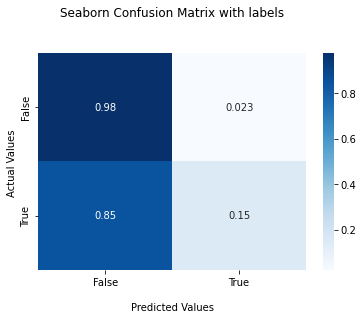

In [47]:
cf_matrix = confusion_matrix(y_test, y_pred_test)
cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [48]:
"""# identify important features
importance = model.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
f, ax = plt.subplots(figsize=(15, 6))
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=45)
plt.show()"""

"# identify important features\nimportance = model.feature_importances_\n\nfor i,v in enumerate(importance):\n\tprint('Feature: %0d, Score: %.5f' % (i,v))\n\n# plot feature importance\nf, ax = plt.subplots(figsize=(15, 6))\nplt.bar([x for x in range(len(importance))], importance)\nplt.xticks(range(X_train.shape[1]), X_train.columns, rotation=45)\nplt.show()"

# Train on Entire train_history

In [49]:
model = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=15, min_samples_split=60, random_state=42)
model.fit(X, y)

RandomForestClassifier(max_depth=10, min_samples_leaf=15, min_samples_split=60,
                       n_estimators=300, random_state=42)

# Generate prediction set

In [50]:
# Generate prediction features (for blind test)
predict_features = test_history.merge(trans_features, on='id', how='left')
predict_features.recency.fillna(365, inplace=True)
predict_features.frequency.fillna(0, inplace=True)
predict_features.monetary.fillna(0, inplace=True)

# merge promo with features
predict_features = predict_features.merge(promos, on='promo', how='left')

# was the promo offered on a weekday or weekend?
predict_features['promo_in_weekend'] = predict_features['promodate'].dt.day_name().isin(['Saturday', 'Sunday']).astype(int)

predict_features = predict_features.merge(category_count, on='category', how='left')
predict_features = predict_features.merge(customer_features, on='id', how='left')
predict_features.total_products_count.fillna(0, inplace=True)
predict_features.unique_products_count.fillna(0, inplace=True)

predict_features = predict_features.merge(customer_product_features, on=['id', 'category'], how='left')
predict_features.head()

,id,store,promo,region,promodate,active,recency,frequency,monetary,category,...,brand,promo_in_weekend,category_count,total_products_count,unique_products_count,total_products_weekend,products_weekend_pct,cust_prod_count,cust_prod_weekend_count,cust_prod_weekend_pct
0,250462324156,457755,96852,191747,2013-04-22,NaN,1.0,0.312155,7346.62,79950300,...,649187428,0,172543,2026.0,304.0,823.0,0.406219,11.0,7.0,0.636364
1,61214568335,740794,54956,203586,2013-04-23,NaN,2.0,0.630854,2845.80,59128902,...,704691081,0,1701,990.0,144.0,195.0,0.196970,NaN,NaN,NaN
2,274776763999,394092,95011,42773,2013-04-02,NaN,5.0,0.351124,1791.99,51006740,...,854156277,0,391325,434.0,143.0,214.0,0.493088,9.0,2.0,0.222222
3,91546215019,876095,108237,323706,2013-04-24,NaN,0.0,0.280992,3661.45,17240091,...,2395929821,0,111786,1048.0,210.0,125.0,0.119275,NaN,NaN,NaN
4,220718580189,625933,222088,191747,2013-04-18,NaN,0.0,0.400552,3093.23,75536470,...,1893579944,0,18518,939.0,250.0,301.0,0.320554,1.0,0.0,0.000000


In [51]:
predict_features.cust_prod_count.fillna(0, inplace=True)
predict_features.total_products_weekend.fillna(0, inplace=True)
predict_features.products_weekend_pct.fillna(0, inplace=True) 
predict_features.cust_prod_weekend_count.fillna(0, inplace=True)
predict_features.cust_prod_weekend_pct.fillna(0, inplace=True)
predict_features.isnull().sum()

id                             0
store                          0
promo                          0
region                         0
promodate                      0
active                     10000
recency                        0
frequency                      0
monetary                       0
category                       0
promoqty                       0
manufacturer                   0
promoval                       0
brand                          0
promo_in_weekend               0
category_count                 0
total_products_count           0
unique_products_count          0
total_products_weekend         0
products_weekend_pct           0
cust_prod_count                0
cust_prod_weekend_count        0
cust_prod_weekend_pct          0
dtype: int64

In [52]:
# converting to categorical features
predict_features = predict_features.astype({"store":'category', "promo":'category', 'region': 'category', 'category': 'category', 'manufacturer': 'category', 'brand':'category'})
predict_features.dtypes

id                                  int64
store                            category
promo                            category
region                           category
promodate                  datetime64[ns]
active                            float64
recency                           float64
frequency                         float64
monetary                          float64
category                         category
promoqty                            int64
manufacturer                     category
promoval                          float64
brand                            category
promo_in_weekend                    int64
category_count                      int64
total_products_count              float64
unique_products_count             float64
total_products_weekend            float64
products_weekend_pct              float64
cust_prod_count                   float64
cust_prod_weekend_count           float64
cust_prod_weekend_pct             float64
dtype: object

In [53]:
X_predict = predict_features[x_cols]
predict_out = predict_features[['id', 'active']].copy()

In [54]:
X_predict.head()

,store,promo,region,recency,frequency,monetary,brand,category_count,total_products_count,unique_products_count,products_weekend_pct,cust_prod_count,cust_prod_weekend_pct
0,457755,96852,191747,1.0,0.312155,7346.62,649187428,172543,2026.0,304.0,0.406219,11.0,0.636364
1,740794,54956,203586,2.0,0.630854,2845.80,704691081,1701,990.0,144.0,0.196970,0.0,0.000000
2,394092,95011,42773,5.0,0.351124,1791.99,854156277,391325,434.0,143.0,0.493088,9.0,0.222222
3,876095,108237,323706,0.0,0.280992,3661.45,2395929821,111786,1048.0,210.0,0.119275,0.0,0.000000
4,625933,222088,191747,0.0,0.400552,3093.23,1893579944,18518,939.0,250.0,0.320554,1.0,0.000000


# Generate Prediction

In [55]:
predict_out.head()

,id,active
0,250462324156,NaN
1,61214568335,NaN
2,274776763999,NaN
3,91546215019,NaN
4,220718580189,NaN


In [56]:
predict_out['active'] = model.predict_proba(X_predict)[:, 1]
predict_out.head()

,id,active
0,250462324156,0.187748
1,61214568335,0.087267
2,274776763999,0.391732
3,91546215019,0.216775
4,220718580189,0.200870


In [57]:
predict_out.to_csv('predict.csv', header=True, index=False)
predict_out.head()

,id,active
0,250462324156,0.187748
1,61214568335,0.087267
2,274776763999,0.391732
3,91546215019,0.216775
4,220718580189,0.200870


In [58]:
# This will download your prediction files
from google.colab import files
files.download('predict.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>